First we have to download and install the pip package

In [ ]:
!pip3 install -U ncps pytorch-lightning

In [ ]:
from IPython.display import clear_output, display
import numpy as np
import torch.nn as nn
from ncps.wirings import AutoNCP
from ncps.torch import LTC
import pytorch_lightning as pl
import torch
import torch.utils.data as data

For the training we will use Pytorch-Lightning, thus we have to define our learner module.

In [ ]:
# LightningModule for training a RNNSequence module
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr
        self.step=0

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)

        # plot
        if self.step%10==0:
          clear_output(wait=True)
          data_x = x.detach().numpy()
          prediction = y_hat.detach().numpy()
          plt.figure(figsize=(6, 4))

          plt.plot(data_x[0, :, 0], label="Input feature 1",marker='.',markersize=10)
          plt.plot(data_x[0, :, 1], label="Input feature 2",marker='.',markersize=10)
          plt.plot(data_y[0, :, 0], label="Target output",marker='.',markersize=10)
          plt.plot(prediction[0, :, 0], label="NCP output",marker='.',markersize=10)
          plt.ylim((-1, 1))
          plt.title(f"training {self.step:03}")
          plt.legend(loc="upper right")
          plt.show()
        self.step+=1
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)


Data Loader Collate function for data augumentation

In [ ]:
def collate_fn(batch):
    """
    Collate function for data augmentation
    """
    #batch[0] size: 2
    #batch[0][0] size: torch.Size([48, 2])

    data_xs = []
    data_ys = []
    for data_x, data_y in batch:
        # print(f"data_x.shape: {data_x.shape}")
        # print(f"data_y.shape: {data_y.shape}")
        N = data_x.shape[0]
        data_t = np.random.default_rng().uniform(0.0,0.999, size=N)
        # data_t = np.expand_dims(data_t, axis=1)
        # data_t = torch.Tensor(data_t)
        new_data_x = []
        new_data_y = []
        for i in range(0,N-1):
          dx1 = data_x[i+1][0] - data_x[i][0]
          dx2 = data_x[i+1][1] - data_x[i][1]
          dy  = data_y[i+1][0] - data_y[i][0]
          data_x2 = np.array([data_x[i][0] + dx1*data_t[i]
                             ,data_x[i][1] + dx2*data_t[i]])
          data_y2 = [data_y[i][0] + dy*data_t[i]]
          new_data_x.append(data_x2)
          new_data_y.append(data_y2)

        new_data_x.append(data_x[N-1])
        new_data_y.append(data_y[N-1])
        new_data_x = torch.Tensor(new_data_x)
        new_data_y = torch.Tensor(new_data_y)
        new_data_y = new_data_y.reshape(data_y.shape)
        #print(f"new_data_x={new_data_x.shape}")
        #print(f"new_data_y={new_data_y.shape}")
        data_xs.append(new_data_x)
        data_ys.append(new_data_y)

    data_xs = torch.stack(data_xs)
    data_ys = torch.stack(data_ys)
    return data_xs, data_ys

Next we define some toy dataset and create the corresponding DataLoaders

data_x.size:  torch.Size([1, 48, 2])
data_y.size:  torch.Size([1, 48, 1])


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


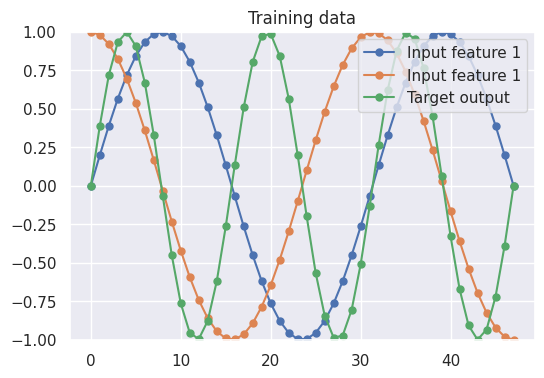

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

in_features = 2
out_features = 1
N = 48  # Length of the time-series
# Input feature is a sine and a cosine wave
data_x = np.stack(
    [np.sin(np.linspace(0, 3 * np.pi, N)), np.cos(np.linspace(0, 3 * np.pi, N))], axis=1
)
data_x = np.expand_dims(data_x, axis=0).astype(np.float32)  # Add batch dimension
# Target output is a sine with double the frequency of the input signal
data_y = np.sin(np.linspace(0, 6 * np.pi, N)).reshape([1, N, 1]).astype(np.float32)
data_x = torch.Tensor(data_x)
data_y = torch.Tensor(data_y)
print("data_x.size: ", str(data_x.size()))
print("data_y.size: ", str(data_y.size()))
dataloader = data.DataLoader(
    data.TensorDataset(data_x, data_y),
    batch_size=1, shuffle=True, num_workers=4,
    collate_fn=collate_fn
)
# Let's visualize the training data
sns.set()
plt.figure(figsize=(6, 4))
plt.plot(data_x[0, :, 0], label="Input feature 1",marker='.',markersize=10)
plt.plot(data_x[0, :, 1], label="Input feature 1",marker='.',markersize=10)
plt.plot(data_y[0, :, 0], label="Target output",marker='.',markersize=10)
plt.ylim((-1, 1))
plt.title("Training data")
plt.legend(loc="upper right")
plt.show()

Here we can finally create a LTCCell and make use of the predefined sparse wiring structures of the keras-ncp package. For simplicity we will just define a fully-connected RNN

In [ ]:
#wiring = AutoNCP(16, out_features)  # 16 units, 1 motor neuron
wiring = AutoNCP(5, out_features)  # 5 units, 1 motor neuron

ltc_model = LTC(in_features, wiring, batch_first=True)
learn = SequenceLearner(ltc_model, lr=0.01)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=400,
    gradient_clip_val=1,  # Clip gradient to stabilize training
    devices="auto", # 2,
    accelerator="auto" # "gpu"
)
#Trainer(devices=2, accelerator="auto")
# trainer = pl.Trainer(
#     logger=pl.loggers.CSVLogger("log"),
#     max_epochs=400,
#     gradient_clip_val=1,  # Clip gradient to stabilize training
#     gpus=0,
# )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


alloc!


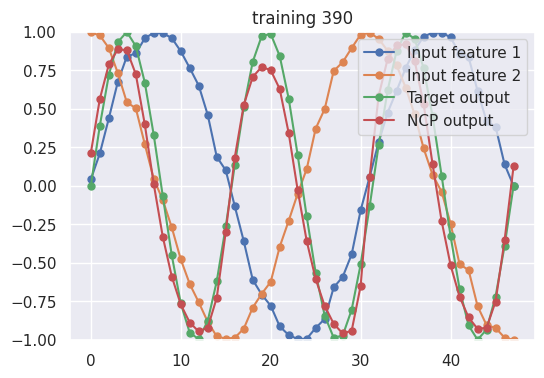

<ipython-input-89-0804ea5b8b91>:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  new_data_x = torch.Tensor(new_data_x)
<ipython-input-89-0804ea5b8b91>:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  new_data_x = torch.Tensor(new_data_x)
<ipython-input-89-0804ea5b8b91>:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  new_data_x = torch.Tensor(new_data_x

In [ ]:
trainer.fit(learn, dataloader)

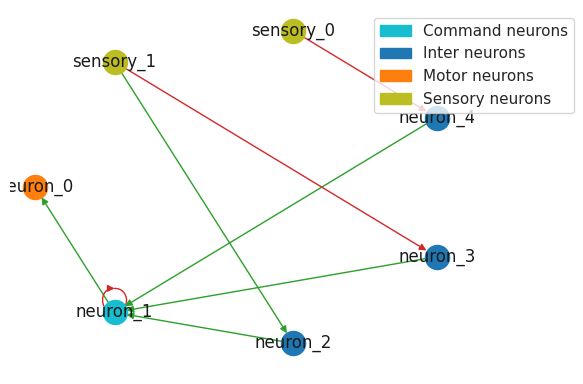

In [ ]:
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = wiring.draw_graph(draw_labels=True,  neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

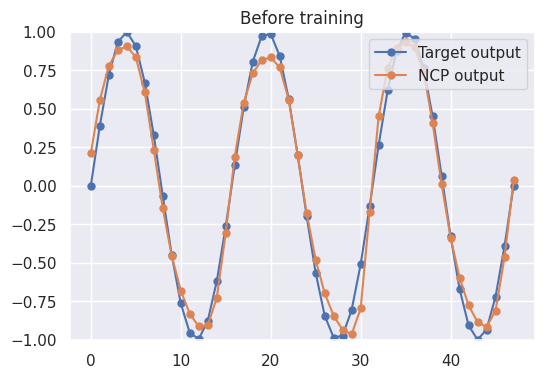

In [ ]:
sns.set()
with torch.no_grad():
  prediction = ltc_model(data_x)[0].numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y[0, :, 0], label="Target output",marker='.',markersize=10)
plt.plot(prediction[0, :, 0], label="NCP output",marker='.',markersize=10)
plt.ylim((-1, 1))
plt.title("Before training")
plt.legend(loc="upper right")
plt.show()

... and train our network

In [ ]:
results = trainer.test(learn, dataloader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |          | 0/? [00:00<?, ?it/s]

<ipython-input-89-0804ea5b8b91>:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  new_data_x = torch.Tensor(new_data_x)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │   0.017360011115670204    │
└───────────────────────────┴───────────────────────────┘

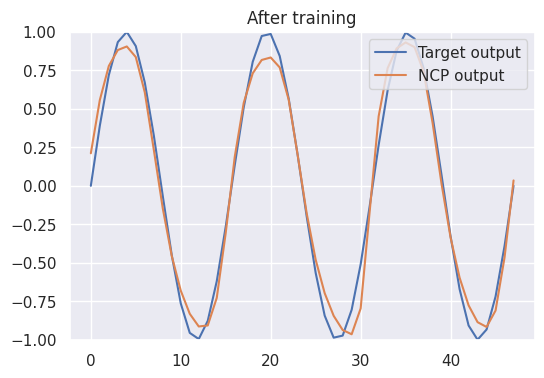

In [ ]:
sns.set()
with torch.no_grad():
  prediction = ltc_model(data_x)[0].numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="NCP output")
plt.ylim((-1, 1))
plt.title("After training")
plt.legend(loc="upper right")
plt.show()